In [1]:
using QuadraticTeamDecisionSolver, Distributions, Statistics, LinearAlgebra, Plots

In [2]:
p = QuadTeamProblem(3, [4, 4, 4], [1, 1, 1], ComplexF64);

In [29]:
t = teamMMSEproblem(0.6309573444801932, [0.0, 0.0, 0.0], [1.0, 1.0, 1.0], [0.0, 0.0, 0.0], [0.5, 0.7, 0.8], [0.2, 0.2, 0.2]);


In [50]:
m = 3000;
iterations = 15;

In [51]:
Y, R, r, c = generateTeamMMSEsamples(p, t, m);

In [52]:
w_jacobi = [[rand(ComplexF64, m)] for _ in 1:p.N];
w_alternating = [[rand(ComplexF64, m)] for _ in 1:p.N];

In [53]:
hₒ = ((4*0.5)/(3*m))^(1/5);
conditionalMean(X, Y, y) = densityConditionalMean(exponentialKernel, X, Y, y, hₒ);

In [54]:
empiricalJacobiSolver!(p, w_jacobi, Y, R, r, conditionalMean, iterations = iterations);


In [55]:
empiricalAlternatingSolver!(p, w_alternating, Y, R, r, conditionalMean, iterations = iterations);

In [56]:
conv_jacobi = [norm.(diff(w_jacobi[i])) for i in 1:p.N];
conv_alternating = [norm.(diff(w_alternating[i])) for i in 1:p.N];

In [57]:
testW_jacobi, testR, testr = reformatData(p.N, m, iterations, w_jacobi, R, r);
testW_alternating, _, _ = reformatData(p.N, m, iterations, w_alternating, R, r);

In [58]:
perf_jacobi = [urisk(testW_jacobi[k], testR, testr, [c for _ in 1:m]) for k in 1:iterations];
perf_alternating = [urisk(testW_alternating[k], testR, testr, [c for _ in 1:m]) for k in 1:iterations];

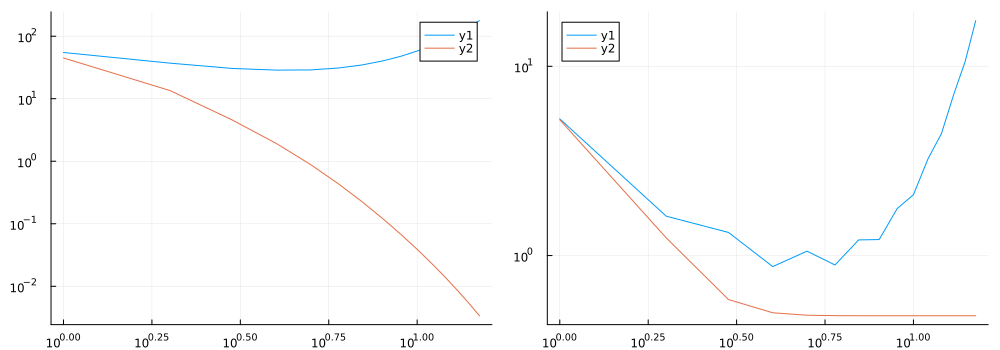

In [59]:
perf = plot([perf_jacobi, perf_alternating], yscale = :log10, xscale = :log10);
conv = plot([sum(conv_jacobi) / length(conv_jacobi), sum(conv_alternating) / length(conv_alternating)], yscale = :log10, xscale = :log10);
plot(conv, perf, layout = (1, 2), size = (1000, 350))
